### Farhana H
### 212223230057
## Exp.No:04

In [49]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [4]:
import os

root = r"C:\Users\admin\Downloads\dogandcat"

print("Root folder exists:", os.path.exists(root))
print("Contents of Cat_Dog:", os.listdir(root))

Root folder exists: True
Contents of Cat_Dog: ['test_set', 'training_set']


In [8]:
import os

root = r"C:\Users\admin\Downloads\dogandcat"
for path, dirs, files in os.walk(root):
    print("📁", path)
    for d in dirs:
        print("   ├──", d)
    for f in files[:5]:  # only first 5 files shown
        print("   ├──", f)
    print()

📁 C:\Users\admin\Downloads\dogandcat
   ├── test_set
   ├── training_set

📁 C:\Users\admin\Downloads\dogandcat\test_set
   ├── test_set

📁 C:\Users\admin\Downloads\dogandcat\test_set\test_set
   ├── cats
   ├── dogs

📁 C:\Users\admin\Downloads\dogandcat\test_set\test_set\cats
   ├── cat.4001.jpg
   ├── cat.4002.jpg
   ├── cat.4003.jpg
   ├── cat.4004.jpg
   ├── cat.4005.jpg

📁 C:\Users\admin\Downloads\dogandcat\test_set\test_set\dogs
   ├── dog.4001.jpg
   ├── dog.4002.jpg
   ├── dog.4003.jpg
   ├── dog.4004.jpg
   ├── dog.4005.jpg

📁 C:\Users\admin\Downloads\dogandcat\training_set
   ├── training_set

📁 C:\Users\admin\Downloads\dogandcat\training_set\training_set
   ├── cats
   ├── dogs

📁 C:\Users\admin\Downloads\dogandcat\training_set\training_set\cats
   ├── cat.1.jpg
   ├── cat.10.jpg
   ├── cat.100.jpg
   ├── cat.1000.jpg
   ├── cat.1001.jpg

📁 C:\Users\admin\Downloads\dogandcat\training_set\training_set\dogs
   ├── dog.1.jpg
   ├── dog.10.jpg
   ├── dog.100.jpg
   ├── dog.1000.j

In [10]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# ✅ Correct paths
train_dir = r"C:\Users\admin\Downloads\dogandcat\training_set"
test_dir = r"C:\Users\admin\Downloads\dogandcat\test_set"

# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')


['training_set']
Training images available: 8005
Testing images available:  2023


In [11]:
VGG19model = models.vgg19(pretrained=True)

In [12]:
# Freeze feature parameters
for param in VGG19model.parameters():
    param.requires_grad = False

In [13]:
# Modify the classifier

torch.manual_seed(42)
VGG19model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim=1)
)

In [14]:
for param in VGG19model.parameters():
    print(param.numel())

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
25690112
1024
2048
2


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG19model.classifier.parameters(), lr=0.001)

In [16]:
# Set time tracking
import time
start_time = time.time()

epochs = 3
max_trn_batch = 88  # As per your dataset size
max_tst_batch = 20  # As per your test dataset size

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1

        # X_train, y_train = X_train.to(device), y_train.to(device)

        # Apply the model
        y_pred = VGG19model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Print interim results
        if b%20==0:
          acc = trn_corr.item()*100 / ((b+1)*train_loader.batch_size)
          print(f'epoch: {i+1}  batch: {b+1} loss: {loss.item():.4f} accuracy: {acc:.2f}%')


    train_losses.append(loss)
    train_correct.append(trn_corr)

    # X_test, y_test = X_test.to(device), y_test.to(device)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = VGG19model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch: 1  batch: 21 loss: 0.0000 accuracy: 91.67%
epoch: 1  batch: 41 loss: 0.0000 accuracy: 95.73%
epoch: 1  batch: 61 loss: 0.0000 accuracy: 97.13%
epoch: 1  batch: 81 loss: 0.0000 accuracy: 97.84%
epoch: 2  batch: 21 loss: 0.0000 accuracy: 95.24%
epoch: 2  batch: 41 loss: 0.0000 accuracy: 97.56%
epoch: 2  batch: 61 loss: 0.0000 accuracy: 98.36%
epoch: 2  batch: 81 loss: 0.0000 accuracy: 98.77%
epoch: 3  batch: 21 loss: 0.0000 accuracy: 95.24%
epoch: 3  batch: 41 loss: 0.0000 accuracy: 97.56%
epoch: 3  batch: 61 loss: 0.0000 accuracy: 98.36%
epoch: 3  batch: 81 loss: 0.0000 accuracy: 98.77%

Duration: 608 seconds


In [17]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

[tensor(40), tensor(40), tensor(40)]
Test accuracy: 1.977%


In [18]:
# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

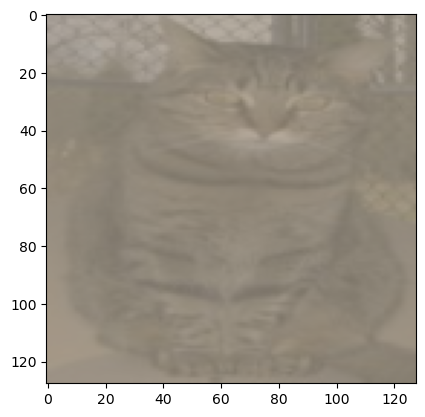

In [19]:
image_index = 16
im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
plt.show()

In [39]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [40]:
# VGG19 Model Prediction:

VGG19model.eval()
with torch.no_grad():
    new_pred = VGG19model(test_data[image_index][0].view(1,3,224,224)).argmax()

class_names[new_pred.item()]

IndexError: list index out of range

In [41]:
import torch
from torchvision import models

# Load pretrained model
VGG19model = models.vgg19(weights='IMAGENET1K_V1')

# Freeze feature extractor
for param in VGG19model.features.parameters():
    param.requires_grad = False

# Modify classifier for 2 outputs
VGG19model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)

# (Optional) Load your trained weights if you have them
# VGG19model.load_state_dict(torch.load("vgg19_catdog.pth"))

VGG19model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [42]:
from torchvision import transforms

image_index = 0
img, label = test_data[image_index]

img = img.unsqueeze(0)  # shape (1,3,224,224)

with torch.no_grad():
    preds = VGG19model(img)
    pred_label = preds.argmax(dim=1).item()

print("Predicted Class:", class_names[pred_label])


Predicted Class: cats


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG19model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [46]:
test_load_all = DataLoader(test_data, batch_size=4, shuffle=False)


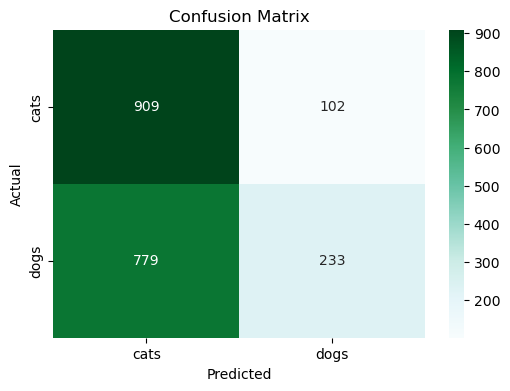

In [47]:
import torch
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

VGG19model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = VGG19model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
arr = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(arr, index=class_names, columns=class_names)

plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="BuGn")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [48]:
accuracy = sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 56.45%
